In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import (
    RocCurveDisplay, 
    ConfusionMatrixDisplay, 
    PrecisionRecallDisplay
)
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    confusion_matrix, 
    precision_recall_curve, 
    roc_curve
)
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import NearestNeighbors
import random

# HYPER-PARAMETERS

In [2]:
TEST_SIZE = 0.2
N_SPLITS = 5
REGRESSION_C = 100
# L1_RATIO = 0.5
RADIUS_NEIGHBORS = 0.4
RANDOM_STATE = 341

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [3]:
def reduce_mem_usage(df : pd.DataFrame):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo('f2').min and c_max < np.finfo('f2').max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo('f4').min and c_max < np.finfo('f4').max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == 'int':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo('i1').min and c_max < np.iinfo('i1').max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo('i2').min and c_max < np.iinfo('i2').max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo('i4').min and c_max < np.iinfo('i4').max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo('i8').min and c_max < np.iinfo('i8').max:
                df[col] = df[col].astype(np.int64)
        elif str(col_type)[:8] == 'datetime':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Потребление памяти меньше на',
         round(start_mem - end_mem, 2),
         'Мб (минус',
         round(100 * (start_mem - end_mem) / start_mem, 1),
         '%)')
    return df

In [4]:
methods = {
    "SHG Intensity" : [
        "SHG Intensity Mean",
        "SHG Intensity MAD",
        "SHG Intensity Contrast",
        "SHG Intensity Correlation",
        "SHG Intensity Entropy",
        "SHG Intensity ASM",
        "SHG Intensity IDM"
    ],
    "R-Ratio" : [
        "R-Ratio Mean",
        "R-Ratio MAD",
        "R-Ratio Contrast",
        "R-Ratio Correlation",
        "R-Ratio Entropy",
        "R-Ratio ASM"
    ],
    "Degree of Circular Polarization" : [
        "Degree of Circular Polarization Mean",
        "Degree of Circular Polarization MAD",
        "Degree of Circular Polarization Contrast",
        "Degree of Circular Polarization Correlation",
        "Degree of Circular Polarization Entropy",
        "Degree of Circular Polarization ASM",
        "Degree of Circular Polarization IDM"
    ],
    "SHG-CD" : [ 
        "SHG-CD MAD",
        "SHG-CD Contrast",
        "SHG-CD Correlation",
        "SHG-CD Entropy",
        "SHG-CD ASM",
        "SHG-CD IDM"
    ],
    "SHG-LD" : [
        "SHG-LD MAD",
        "SHG-LD Contrast",
        "SHG-LD Correlation",
        "SHG-LD Entropy",
        "SHG-LD ASM",
        "SHG-LD IDM"
    ],
    "Params" : [
        "2-Group Tag",
        "Pixel Density",
    ]
}

x_axis = []
for key in methods.keys():
    if key != "Params":
        x_axis += methods[key]
y_axis = methods["Params"][0]

data = pd.DataFrame()

for i in range(0, 9):
    data = pd.concat(
        [data, pd.read_excel(io="../Data/41598_2022_13623_MOESM3_ESM.xlsx", 
        sheet_name=f"{1 << 2 * i} Subimage Training")], ignore_index=True
        )
data = reduce_mem_usage(data)

# data = (data - data.min()) / (data.max() - data.min())
data = data / data.max()
data["2-Group Tag"] = data[y_axis] == 1
data.head()


Потребление памяти меньше на 29.26 Мб (минус 74.6 %)


,2-Group Tag,SHG Intensity Mean,SHG Intensity MAD,SHG Intensity Contrast,SHG Intensity Correlation,SHG Intensity Entropy,SHG Intensity ASM,SHG Intensity IDM,R-Ratio Mean,R-Ratio MAD,...,SHG-CD Entropy,SHG-CD ASM,SHG-CD IDM,SHG-LD MAD,SHG-LD Contrast,SHG-LD Correlation,SHG-LD Entropy,SHG-LD ASM,SHG-LD IDM,Pixel Density
0,False,0.186706,0.261949,0.318217,0.935700,0.926206,0.000559,0.118341,0.780688,0.649017,...,0.950273,0.000089,0.037604,0.706660,0.678306,0.905586,0.974985,0.000339,0.144226,0.247907
1,False,0.193692,0.276326,0.277170,0.930041,0.936665,0.000589,0.117453,0.764660,0.671710,...,1.000000,0.000055,0.030332,0.686833,0.895988,0.869501,0.985967,0.000356,0.129984,1.000000
2,False,0.189035,0.270911,0.382134,0.888889,0.943056,0.000552,0.112506,0.774433,0.647504,...,0.979115,0.000069,0.034626,0.684799,0.885587,0.871478,0.992068,0.000290,0.128366,0.625417
3,False,0.145216,0.192681,0.183444,0.896605,0.888437,0.000830,0.137113,0.777561,0.677005,...,0.981104,0.000067,0.034384,0.730554,0.875929,0.888779,0.992678,0.000297,0.130373,0.513073
4,False,0.110923,0.150299,0.135164,0.912551,0.822196,0.001637,0.178716,0.750586,0.703480,...,0.997514,0.000051,0.027424,0.717336,0.979198,0.873950,1.000000,0.000269,0.114837,0.450847


# Получение модели

In [11]:
def getModel(X, y):
    estimator = SVC(
        C=REGRESSION_C,
        kernel='linear',
        random_state=RANDOM_STATE,
        class_weight='balanced'
    )
    return estimator.fit(X, y)
    # estimanor = LogisticRegression(max_iter=40000, random_state=RANDOM_STATE)
    # return GridSearchCV(estimanor, param_grid, scoring='roc_auc').fit(X, y)


    # return LogisticRegression(
    #     max_iter=40000, 
    #     penalty='l2',
    #     solver='newton-cholesky', 
    #     # l1_ratio=L1_RATIO,
    #     C=REGRESSION_C,
    #     class_weight='balanced'
    # ).fit(X, y)


    

In [6]:
def getPredict(model, X):
    y = model.predict(X)
    return y

# Оценка качества модели

In [7]:
def modelQualityAssessment(model, X_test, y_test):
    y_predict = getPredict(model, X_test)

    print(f'Accuracy score: %0.2f' % accuracy_score(y_test, y_predict, normalize=True))
    print(f'F1 score: %0.2f' % f1_score(y_test, y_predict, average='weighted'))
    print(f'Precision score: %0.2f' % precision_score(y_test, y_predict, average='weighted'))
    print(f'Recall score: %0.2f' % recall_score(y_test, y_predict, average='weighted'))
    print(f'ROC AUC score: %0.2f' % roc_auc_score(y_test, y_predict, average='weighted'))


    ax = plt.gca()
    svc_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax) #?
    rfc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax) #?
    plt.show()

    cm = confusion_matrix(y_test, y_predict, normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()

# Вычисление модели

In [8]:
def MyTomeLinks(X, y):
    nbrsPositive = NearestNeighbors(n_neighbors=1).fit(X[y == True])
    nbrsNegative = NearestNeighbors(n_neighbors=1).fit(X[y == False])

    distances_positive, indices_positive = nbrsPositive.kneighbors(X[y == False])

    distances_positive = distances_positive.ravel()
    indices_positive = indices_positive.ravel()
    print(max(distances_positive))
    indices_nearest_positive = np.unique(indices_positive[distances_positive < RADIUS_NEIGHBORS])

    distances_false, indices_false = nbrsPositive.kneighbors(X[y == True].iloc[indices_nearest_positive])

    indices_nearest_negative = np.unique(indices_false)
    indices_further_positive = np.unique(indices_positive[distances_positive > RADIUS_NEIGHBORS])


    X_further_positive = X[y == True].iloc[indices_further_positive]
    X_nearest_positive = X[y == True].iloc[indices_nearest_positive]
    X_nearest_negative = X[y == False].iloc[indices_nearest_negative]


    y_further_positive = y[y == True].iloc[indices_further_positive]
    y_nearest_positive = y[y == True].iloc[indices_nearest_positive]
    y_nearest_negative = y[y == False].iloc[indices_nearest_negative]

    indices_further_negative = np.array(random.sample(tuple(X[y == False].index), 2 * len(X_further_positive)))

    X_further_negative = X[y == False].loc[indices_further_negative]
    y_further_negative = y[y == False].loc[indices_further_negative]

    X = pd.concat([X_further_positive, X_nearest_positive, X_nearest_negative, X_further_negative], ignore_index=False)
    y = pd.concat([y_further_positive, y_nearest_positive, y_nearest_negative, y_further_negative], ignore_index=False)

    return X, y

In [12]:
X = data[x_axis]
y = data[y_axis]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)


# X_train, y_train = MyTomeLinks(X_train, y_train)
# X_train, y_train = TomekLinks().fit_resample(X_train, y_train)

model = getModel(X_train, y_train)

Accuracy score: 0.81
F1 score: 0.83
Precision score: 0.88
Recall score: 0.81
ROC AUC score: 0.82


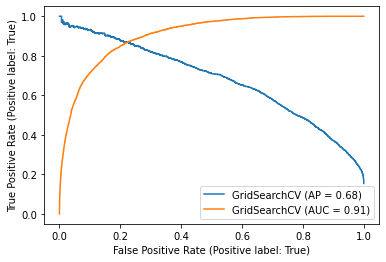

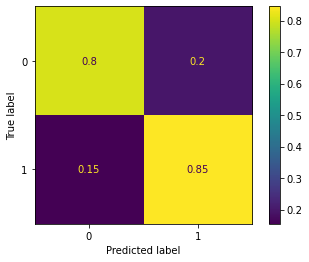

In [ ]:
modelQualityAssessment(model, X_test, y_test)

In [ ]:
cv = ShuffleSplit(n_splits=N_SPLITS, test_size=0.5, random_state=0)
print("%0.3f" % cross_val_score(model, X_test, y_test, cv=cv, scoring='f1_weighted').mean())
print("%0.3f" % cross_val_score(model, X_test, y_test, cv=cv, scoring='roc_auc').mean())

0.889
0.909
